## FNCE30012: Foundations of Fintech - Assignment 2

Below you can find a summary of Assignment 2. However, please note that it is absolutely *crucial* that you carefully read the full assignment instructions in the PDF **Assignment2.pdf** available on LMS.

The aim of this assignment is to build a 'toy robo-adviser' that computes, based on a set of external inputs, the optimal portfolio for a person. The assignment builds on the material covered in Weeks 4 to 6, including online material, lectures and tutorials.

You must **complete** this assignment **by 27<sup>th</sup> of September 2020, 11:59 pm** and submit it through Jupyter Hub.


**The assignment contains four different tasks**:
1. Compute the Sharpe-optimal (optimal risky) portfolio


2. Estimate the client's risk aversion level based on the choices made in a risk elicitation task


3. Explain how to compute, based on the information you have generated, the optimal complete portfolio, that is, the portfolio consisting of a position in a risk-free asset and the Sharpe-optimal (optimal risky) portfolio


4. Compute, based on your computations above, the optimal complete portfolio


### Import your packages in the cell below
**Note:** If you add any additional libraries, you will have to rerun the cell.

In [2]:
# YOUR CODE HERE
import quandl
import matplotlib.pyplot as plt
import seaborn as sns 
import scipy.optimize as sco
import scipy.stats as scs
import numpy as np
import pandas as pd  
import random
np.random.seed(777)
plt.style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Task 1 (3 marks)

#### Task 1 (i) - Code

In [3]:
# YOUR CODE HERE
quandl.ApiConfig.api_key = '7YGa8C1Krr76i84eZHMM'
# define list of stocks
stocks = ['AAPL','AMZN','BRK_B','GOOGL','FB','JNJ','JPM','MSFT','PG','V'] # list of ticker symbols of stocks we want data for

# retrieve data from Quandl
data = quandl.get_table('WIKI/PRICES', ticker = stocks,
                        qopts = { 'columns': ['date', 'ticker', 'adj_close'] },
                        date = { 'gte': '2013-7-1', 'lte': '2018-06-30' }, paginate=True)
data

,date,ticker,adj_close
None,,,
0,2018-03-27,V,117.400000
1,2018-03-26,V,120.640000
2,2018-03-23,V,117.000000
3,2018-03-22,V,119.990000
4,2018-03-21,V,123.220000
...,...,...,...
11923,2013-07-08,AAPL,54.487859
11924,2013-07-05,AAPL,54.798993
11925,2013-07-03,AAPL,55.242720


#### Task 1 (iii) - Code

In [4]:
cov_matrix = returns.cov()
risk_free_rate =  0.00392585794

# define a function that compute annualised return and standard deviation of a portfolio
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns =  np.sum(weights*mean_returns)*252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix,weights))) * np.sqrt(252)
    
    return std, returns
# define a function that compute annualised return and standard deviation of a portfolio
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns =  np.sum(weights*mean_returns)*252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix,weights))) * np.sqrt(252)
    
    return std, returns

def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_std, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_std

def min_variance(mean_returns, cov_matrix):
    '''find minimum variance (volatility) portfolio using optimisation '''
    num_assets = len(mean_returns)
    args =(mean_returns, cov_matrix)
    contraints = ({'type':'eq','fun': lambda x: np.sum(x) - 1})
    results = sco.minimize(portfolio_volatility, num_assets * [1./ num_assets], args=args,
                                                              method= 'SLSQP', constraints=contraints)
    return results

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    ''' function to compute maximum Sharpe ratio portfolio using optimisation '''
    num_assets = len(mean_returns)
    args =(mean_returns, cov_matrix, risk_free_rate)
    contraints = ({'type':'eq','fun': lambda x: np.sum(x) - 1})
    sharpe_ratio = sco.minimize(neg_sharpe_ratio, num_assets * [1./ num_assets], args=args,
                                                              method= 'SLSQP', constraints=contraints)
    return sharpe_ratio

def efficient_return(mean_returns, cov_matrix, target):
    ''' compute efficient portfolio for a given target return'''
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)    

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    
    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    
    result = sco.minimize(portfolio_volatility, num_assets * [1.  /num_assets, ], args=args, method='SLSQP', 
                           constraints=constraints)
    return result

def efficient_frontier(mean_returns, cov_matrix, returns_range):
    ''' find efficient frontier '''
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients


# define function to computing elements of plot and produce plot
def calculated_ef(mean_returns, cov_matrix, risk_free_rate):
    ''' disply optimal portfolio '''
    
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i * 100, 3) for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    max_sharpe_allocation

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i * 100, 3) for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    an_vol = np.std(returns) * np.sqrt(252)
    an_rt = mean_returns * 252
    
    print("-" * 80)
    print("Maximum Sharpe ratio portfolio allocation\n")
    print("Annualised return:", round(rp, 3))
    print("Annualised volatility:", round(sdp, 3))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum variance portfolio allocation\n")
    print("Annualised return:", round(rp_min, 3))
    print("Annualised volatility:", round(sdp_min, 3))
    print("\n")
    print(min_vol_allocation)
    print("-"*80)
    print("Individual stock returns and volatility\n")
    for i, txt in enumerate(table.columns):
        print("%s: annualised return: %0.3f, annualised volatility: %0.3f" % (txt, round(an_rt[i], 3), round(an_vol[i], 3)))
    print("-"*80)    
    return
calculated_ef(mean_returns, cov_matrix, risk_free_rate)
# The efficient frontier is the range of allocations that minimise volatility(standard deviation) for a given target of expected return 

--------------------------------------------------------------------------------
Maximum Sharpe ratio portfolio allocation

Annualised return: 0.444
Annualised volatility: 0.243


              AAPL    AMZN   BRK_B      FB   GOOGL    JNJ     JPM    MSFT  \
allocation  34.025  36.764 -20.623  32.318 -31.396  30.34  22.859  22.787   

                PG       V  
allocation -41.792  14.719  
--------------------------------------------------------------------------------
Minimum variance portfolio allocation

Annualised return: 0.105
Annualised volatility: 0.116


             AAPL   AMZN   BRK_B     FB  GOOGL     JNJ    JPM   MSFT     PG  \
allocation  7.772  1.397  17.797  1.332   2.55  26.792 -0.336 -1.744  43.95   

               V  
allocation  0.49  
--------------------------------------------------------------------------------
Individual stock returns and volatility

AAPL: annualised return: 0.268, annualised volatility: 0.229
AMZN: annualised return: 0.395, annualised volatili

Text(0, 0.5, 'price in $')

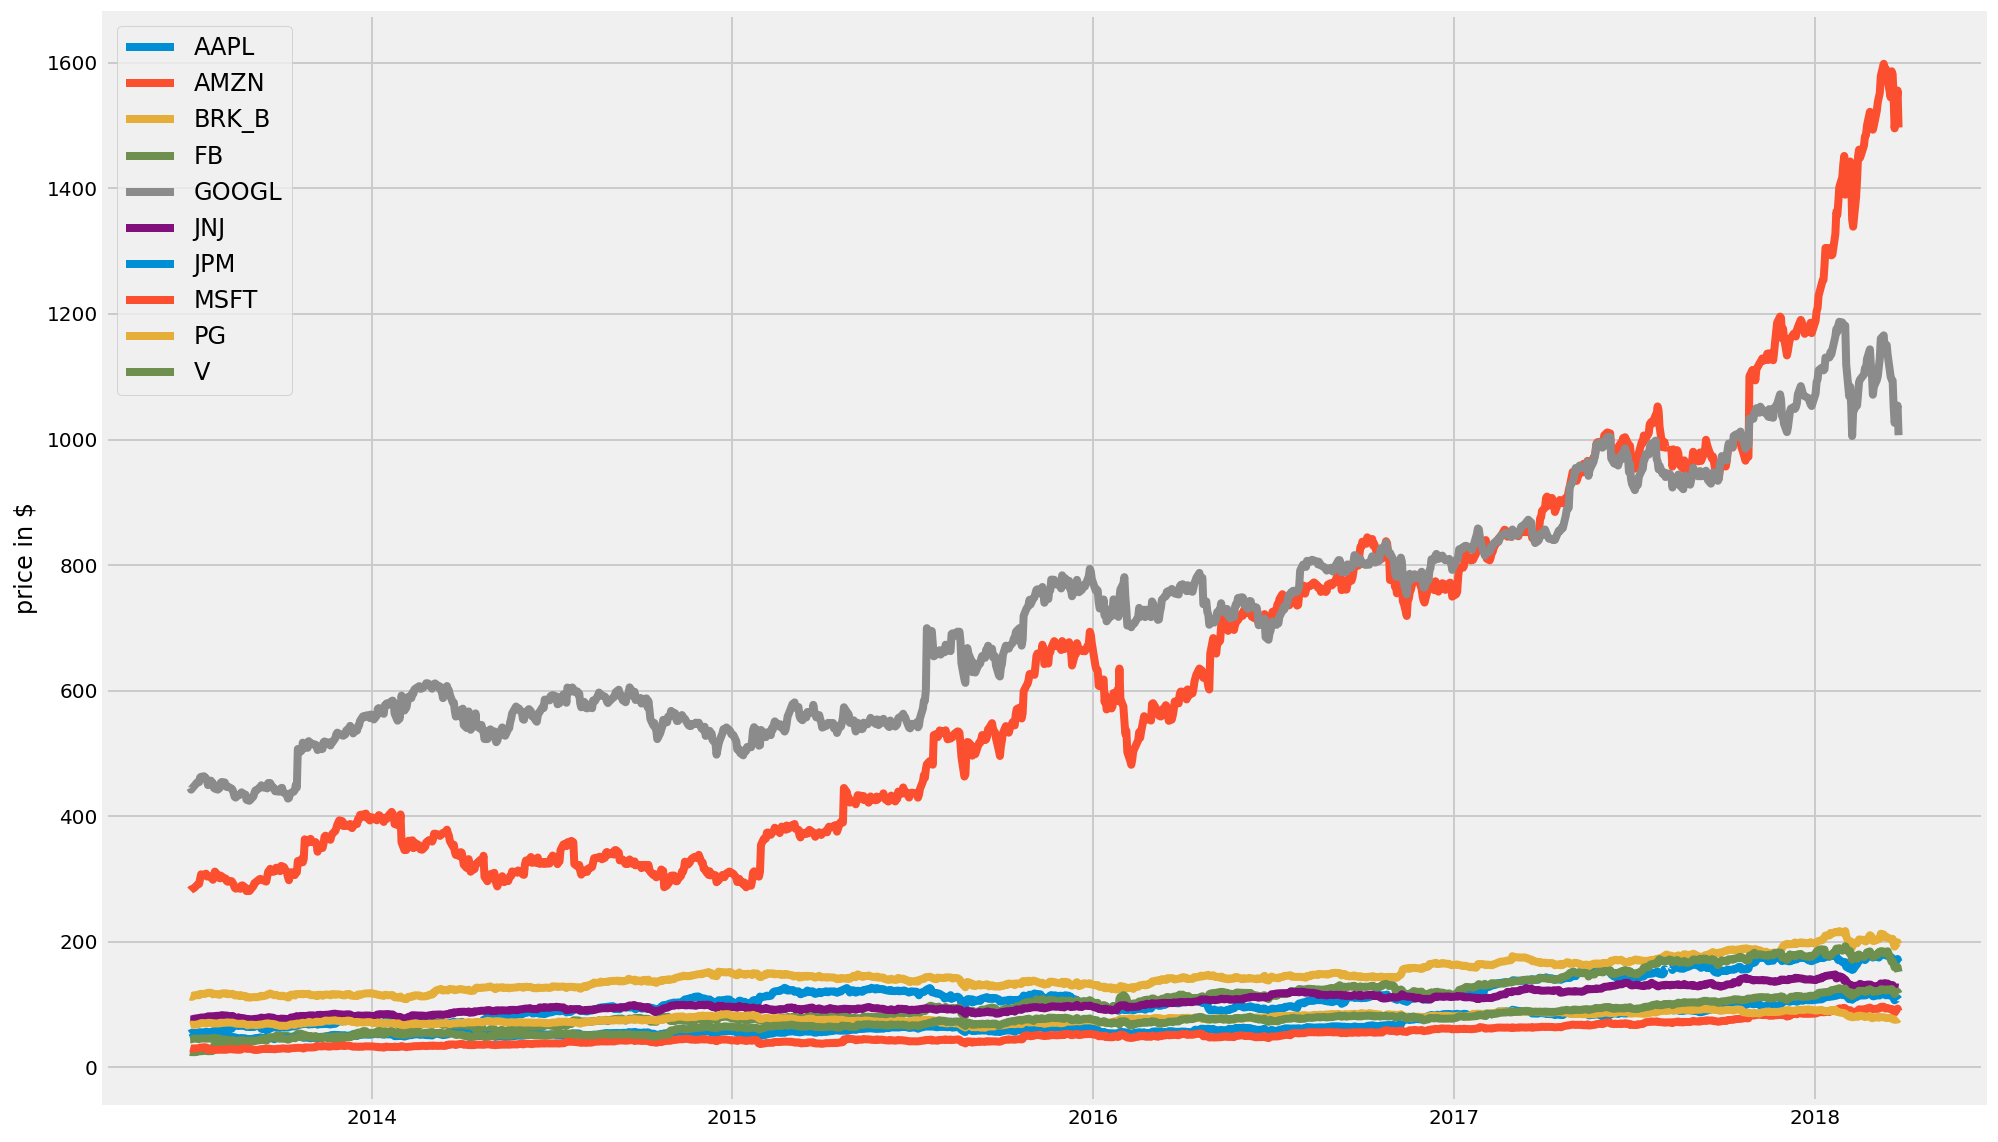

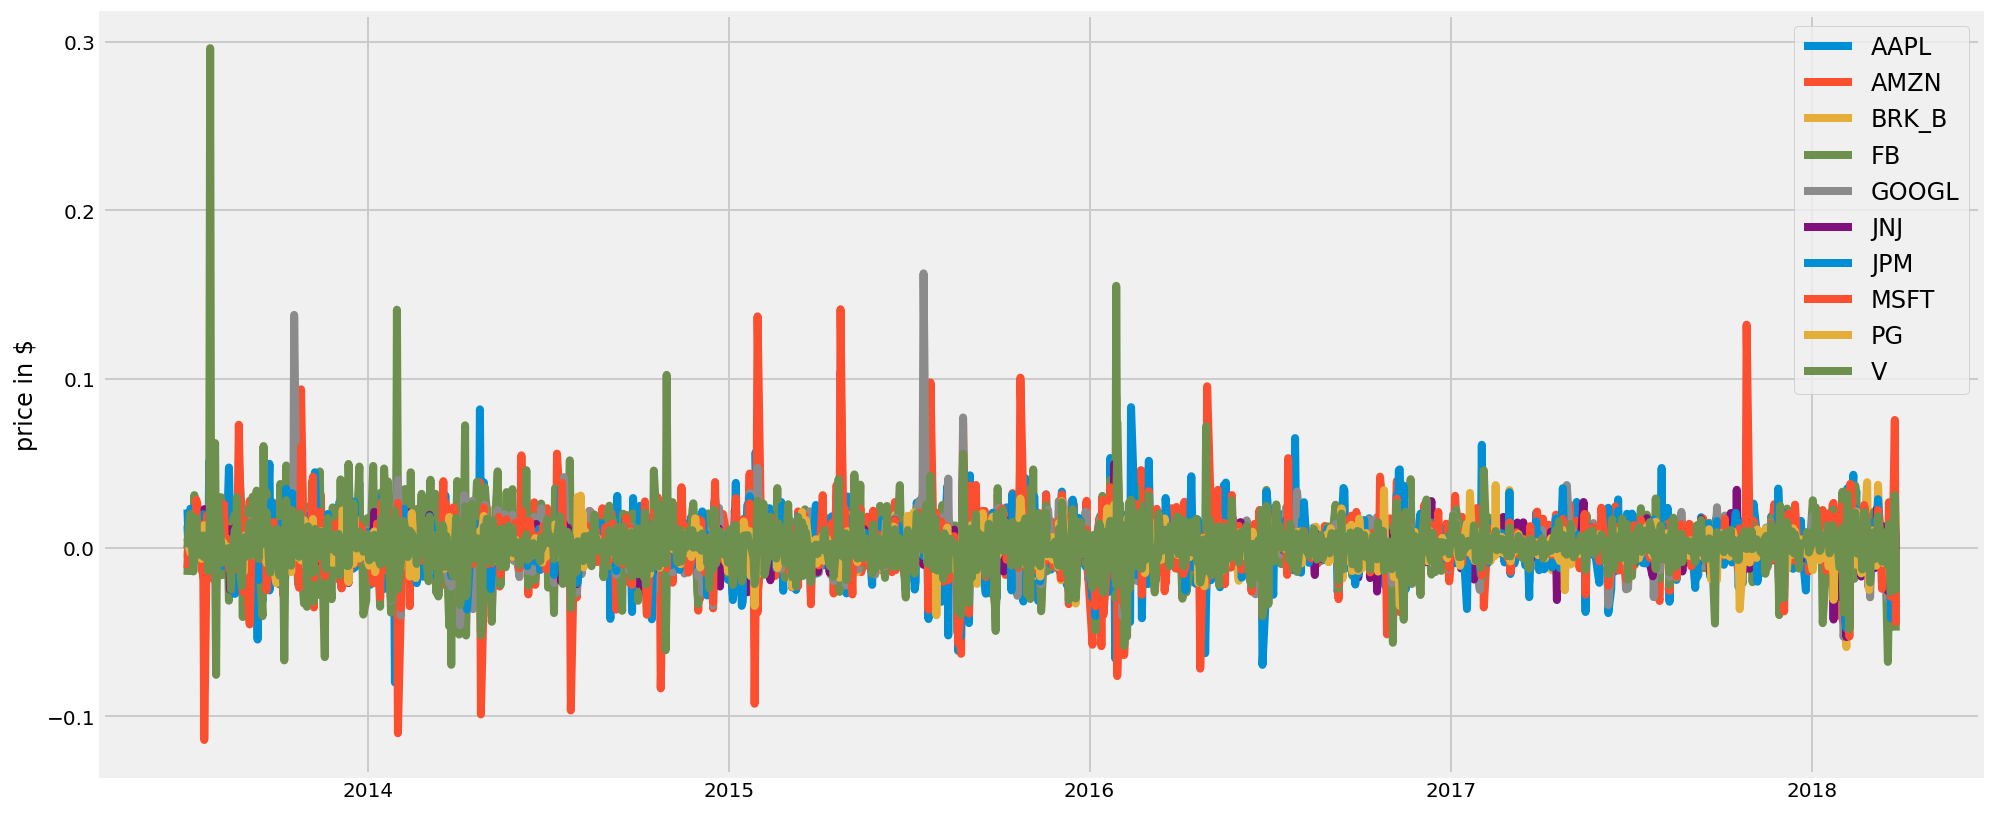

In [4]:
# YOUR CODE HERE
#  set date as row index and organise data as table with one column per stock
df = data.set_index('date')
df.head()
table = df.pivot(columns='ticker')
table.columns = [col[1] for col in table.columns]
table.head()
# plot stock prices
plt.figure(figsize=(15,10))
for c in table.columns.values:
    plt.plot(table.index,table[c])
plt.legend(table,loc='upper left', fontsize=12)
plt.ylabel('price in $')

# compute daily returns from prices and mean returns
returns = table.pct_change()
mean_returns = returns.mean()
# plot return time series
plt.figure(figsize=(15,7))
for r in returns.columns.values:
    plt.plot(returns.index,returns
             [r])
plt.legend(table,loc='upper right', fontsize=12)
plt.ylabel('price in $')

In [5]:

cov_matrix

,AAPL,AMZN,BRK_B,FB,GOOGL,JNJ,JPM,MSFT,PG,V
AAPL,0.000209,0.000086,0.000051,0.000094,0.000078,0.000038,0.000066,0.000087,0.000034,0.000066
AMZN,0.000086,0.000339,0.000057,0.000166,0.000147,0.000047,0.000073,0.000114,0.000034,0.000104
BRK_B,0.000051,0.000057,0.000092,0.000062,0.000059,0.000052,0.000090,0.000066,0.000039,0.000067
FB,0.000094,0.000166,0.000062,0.000408,0.000141,0.000049,0.000077,0.000100,0.000028,0.000110
GOOGL,0.000078,0.000147,0.000059,0.000141,0.000204,0.000049,0.000070,0.000107,0.000037,0.000089
JNJ,0.000038,0.000047,0.000052,0.000049,0.000049,0.000085,0.000052,0.000048,0.000038,0.000053
JPM,0.000066,0.000073,0.000090,0.000077,0.000070,0.000052,0.000168,0.000083,0.000036,0.000082
MSFT,0.000087,0.000114,0.000066,0.000100,0.000107,0.000048,0.000083,0.000212,0.000046,0.000087
PG,0.000034,0.000034,0.000039,0.000028,0.000037,0.000038,0.000036,0.000046,0.000074,0.000041
V,0.000066,0.000104,0.000067,0.000110,0.000089,0.000053,0.000082,0.000087,0.000041,0.000166


#### Task 1 (iv) - Code

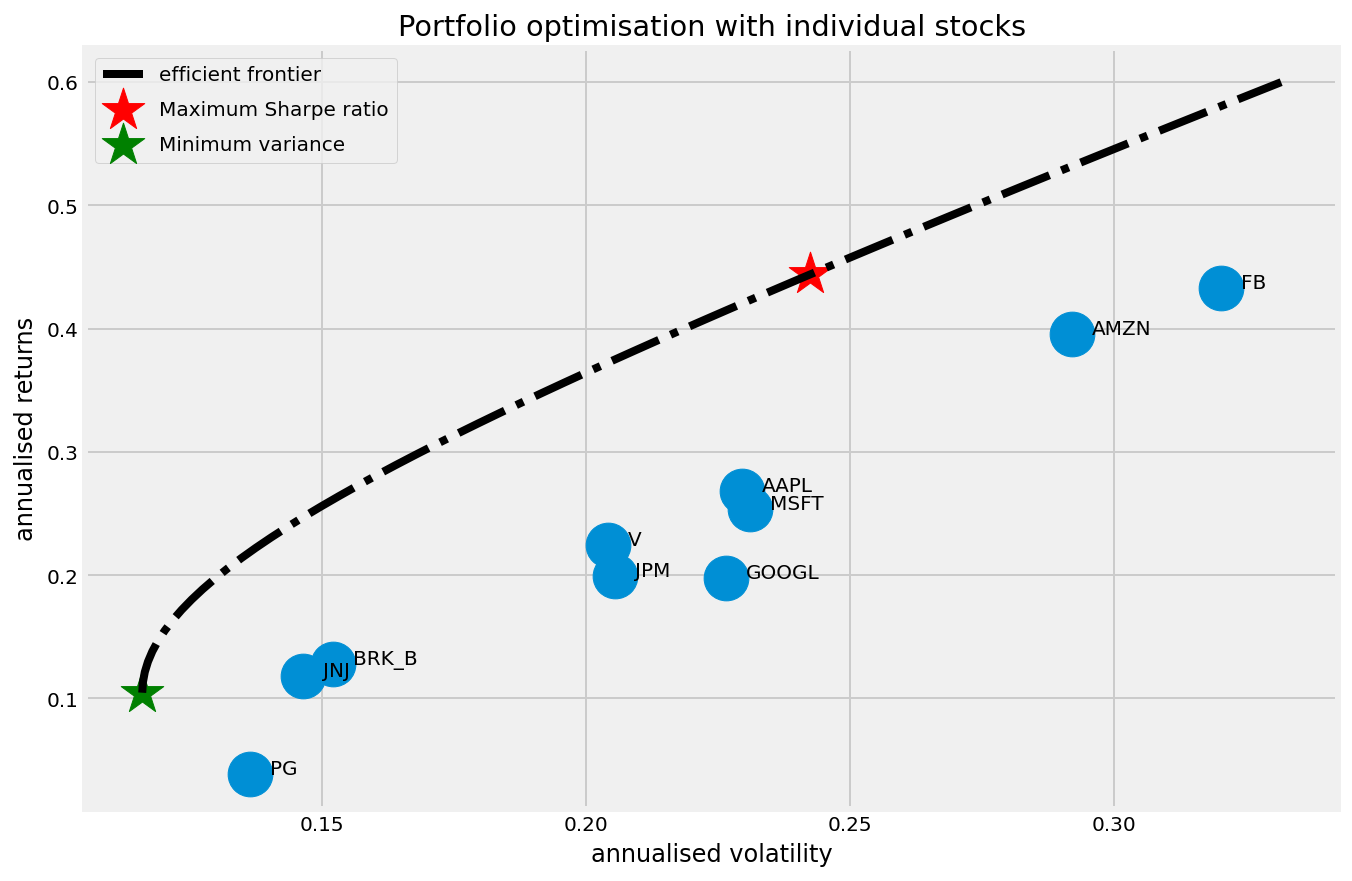

In [5]:
def display_calculated_ef(mean_returns, cov_matrix, risk_free_rate):
    ''' disply optimal portfolio '''
    
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i * 100, 3) for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    max_sharpe_allocation

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i * 100, 3) for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    an_vol = np.std(returns) * np.sqrt(252)
    an_rt = mean_returns * 252
   
    
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(an_vol,an_rt,marker='o',s=500)

    for i, txt in enumerate(table.columns):
        ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
    ax.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    ax.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum variance')

    target = np.linspace(rp_min, 0.6, 60)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)

    
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    
    ax.set_title('Portfolio optimisation with individual stocks')
    ax.set_xlabel('annualised volatility')
    ax.set_ylabel('annualised returns')
    ax.legend(labelspacing=0.8)
    return
display_calculated_ef(mean_returns, cov_matrix, risk_free_rate)

## Task 2 (3 marks)

#### Task 2 (i) - Code

In [6]:
# YOUR CODE HERE
tp = np.array(pd.read_csv('task-params-2.csv', sep=',', header=None))
tp_df = pd.DataFrame(tp, columns=['p1(A)', 'r1(A)', 'p2(A)', 'r2(A)', 'p1(B)', 'r1(B)', 'p2(B)', 'r2(B)'])


#### Task 2 (ii) - Code

In [7]:
# YOUR CODE HERE
choices_df = pd.read_csv('choices.csv', sep=',', header=None)
choices = choices_df[0].tolist()



#### Task 2 (iii) - Code

In [37]:
# YOUR CODE HERE
# define utility function
def util(p0, r0, p1, r1, alpha):
    ev = p0 * r0 + p1 * r1 # expected value
    var = p0 * (r0 - ev)**2 + p1 * (r1 - ev)**2 # variance
    u = ev - np.exp(np.log(alpha)) * var # utility
    return u
# define softmax function
def softmax(x, beta):
    p = np.minimum( np.maximum( 1 / (1 + np.exp(- np.exp(np.log(beta)) * x )), 10^(-15) ), 1 - 10^(-15) )
    return p

trial_sequence = [i for i in range(0, tp.shape[0])]
def nllfunc(params, tp, trial_sequence, choices):
    '''set up log likelihood function '''
    alpha, beta = params
    nll = 0

    for t in range(0, len(trial_sequence)):
        u0 = util(tp[t][0], tp[t][1], tp[t][2], tp[t][3], alpha)
        u1 = util(tp[t][4], tp[t][5], tp[t][6], tp[t][7], alpha)
        p = softmax(u0 - u1, beta)
        prob = scs.binom.pmf(choices[t], 1, p)
        nll += -np.log(prob)
        
    return nll
def fit_params(tp, trial_sequence, choices):
    args = (tp, trial_sequence, choices)
    bounds = ((0,10),(0,20))
    result = sco.minimize(nllfunc,[0,0],args = args,
                         method='L-BFGS-B', bounds = bounds, options={'maxiter': 5000})
    return result 

alpha = fit_params(tp, trial_sequence, choices)['x']
print("The risk aversion component alpha is:", alpha[0])


The risk aversion component alpha is: 1.3426016125111684


## Task 3 (1 mark)

#### Task 3 - Markdown

We can estimate our optimal complete portfolio based on the risk preference estimate of alpha we estimated, risk free rate and expected return of the optimal portfolio by finding the combination of weights in the risk free rate and optimal portfolio that maximise the user's utility function. 

We know the user's utility function is : U = $E_r - \alpha \sigma^2
                                           = r_f + w(E_(rp) -r_f) - w^2\sigma_p^2$.
To find the optimum weight we need to differenciate utility with respect to weight (w) to find $\frac{du}{dw}$ and equate it to 0 and we get
$w_{risky\ asset}= \frac{Risk Premium}{2A\sigma^2_p} =\frac{E_(rp) - r_f}{2A\sigma^2_p}$

We know the the annualized expected return of our optimal portfolio is 0.444, risk free rate is 0.00392585794, variance of the optimal portfolio is $\sigma^2 = (0.243)^2 = 0.059049$ and alpha is 1.34260161. If we plug in these values in the above formula we get the weight invested in the risky asset and if subtract this weight from 1, we get the weight invested in the risk free asset. This is the most preferred portfolio by the user based on their risk aversion.



## Task 4 (3 marks)

#### Task 4 (i) - Code

In [52]:
def weight_optimal_portfolio(optimal_expected_return,optimal_sd, risk_free_rate, alpha):
    optimal_variance = optimal_sd**2
    weight = (optimal_expected_return-risk_free_rate)/(2*alpha*optimal_variance)
    return weight
    

#### Task 4 (ii) - Code

In [50]:
def optimal_portfolio_performance(weight,optimal_return,optimal_sd,risk_free_rate):
    returns = (weight*optimal_return) + ((1-weight)*risk_free_rate)
    volatility = weight*optimal_sd
    return returns,volatility

#### Task 4 (iii) - Code

In [51]:
# YOUR CODE HERE
risk_free_rate = 0.00392585794
optimal_return = 0.444
optimal_sd = 0.243
alpha = 1.34260161
weights = weight_optimal_portfolio(optimal_return,optimal_sd, risk_free_rate, alpha)
performance = optimal_portfolio_performance(weights,optimal_return,optimal_sd,risk_free_rate)
print("The fraction of portfolio allocated to optimal risky portfolio is:", round(weights,4))
print("The fraction of portfolio allocated to risk free asset is:", round(1-weights,4))
print(f'The expected return of the complete optimal portfolio is {performance[0]:.3f}.')
print(f'The volatility of the complete optimal portfolio is {performance[1]:.3f}.')

The fraction of portfolio allocated to optimal risky portfolio is: 2.7755
The fraction of portfolio allocated to risk free asset is: -1.7755
The expected return of the complete optimal portfolio is 1.225.
The volatility of the complete optimal portfolio is 0.674.


In [16]:
(optimal_return-risk_free_rate)/0.243**2


7.452694238005725